<a href="https://colab.research.google.com/github/initialkermit/CS131_housing/blob/main/housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check for missing values
!awk -F, '{for(i=1;i<=NF;i++) if($i == "") print "Row " NR " column " i " missing"}' housing.csv > missing_values.txt
# Remove rows with missing total_bedrooms
!awk -F, '{if($5 != "") print}' housing.csv > cleaned_housing.csv
# Filter outliers in median_house_value
!awk -F, 'NR==1 || ($9 <= 500000)' cleaned_housing.csv > no_outliers_housing.csv
# Filter extreme total_rooms
!awk -F, 'NR==1 || ($4 <= 10000)' no_outliers_housing.csv > final_housing.csv
# Count unique ocean_proximity values
!awk -F, 'NR>1 {print $10}' final_housing.csv | sort | uniq -c > ocean_proximity_counts.txt


In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

First 5 rows of the preprocessed dataset:


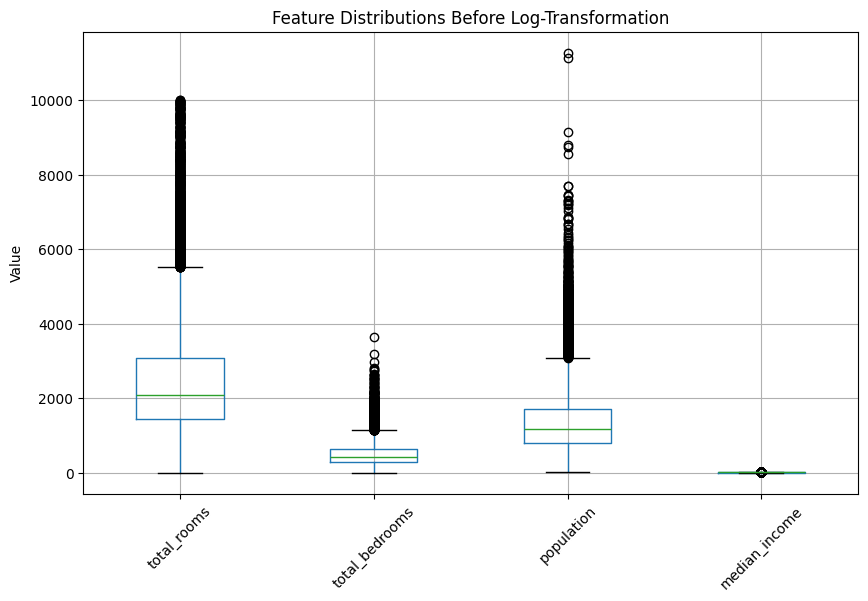

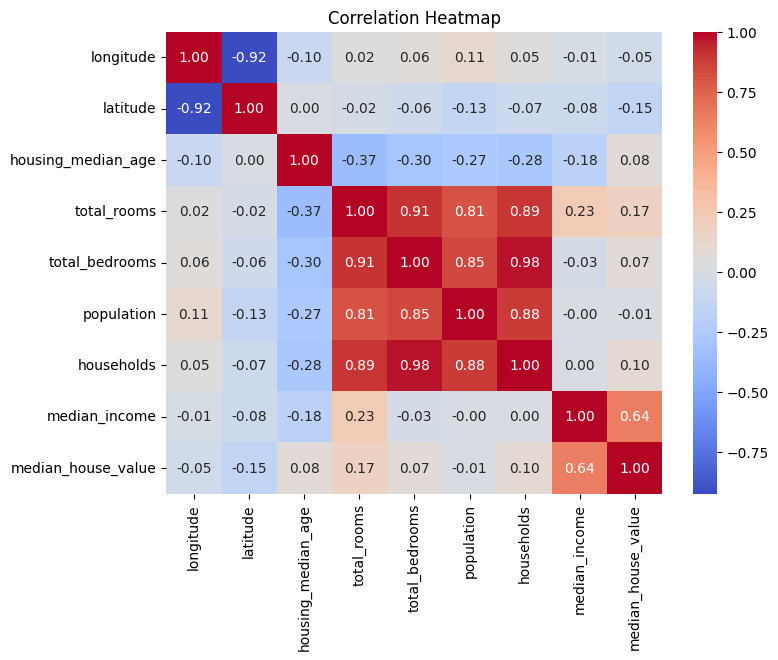

In [3]:
# Load the preprocessed dataset
df = pd.read_csv('final_housing.csv')

# Display the first few rows
print("First 5 rows of the preprocessed dataset:")
df.head()

# Visualize feature distributions before transformation
plt.figure(figsize=(10, 6))
df[['total_rooms', 'total_bedrooms', 'population', 'median_income']].boxplot()
plt.title('Feature Distributions Before Log-Transformation')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Number of rows: 19211
Number of features after encoding: 13


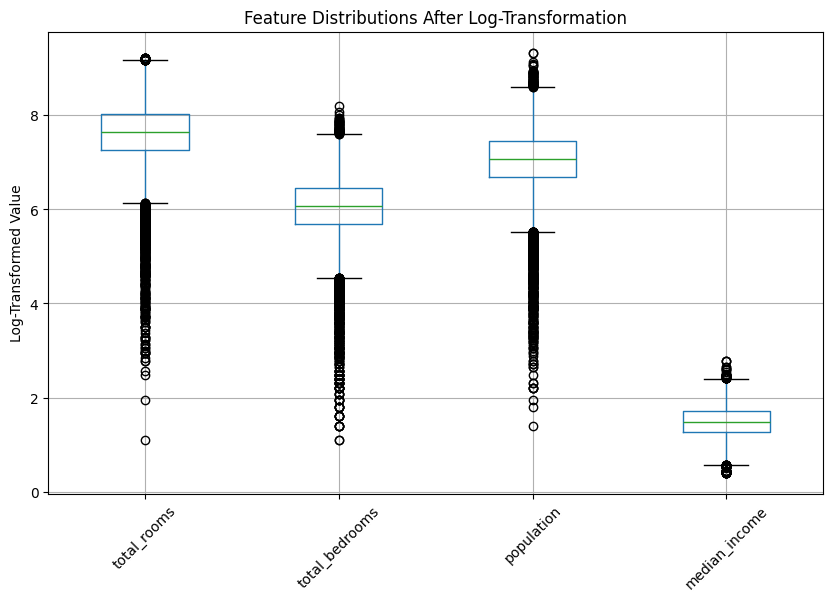

In [4]:
# Log-transform skewed features
for col in ['total_rooms', 'total_bedrooms', 'population', 'median_income']:
    df[col] = np.log1p(df[col])  # log1p handles zero values

# One-hot encode ocean_proximity
df = pd.get_dummies(df, columns=['ocean_proximity'], prefix='ocean')

# Separate features and target
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Scale the target
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Print dataset info
print(f"Number of rows: {len(df)}")
print(f"Number of features after encoding: {X.shape[1]}")

# Visualize feature distributions after transformation
plt.figure(figsize=(10, 6))
df[['total_rooms', 'total_bedrooms', 'population', 'median_income']].boxplot()
plt.title('Feature Distributions After Log-Transformation')
plt.ylabel('Log-Transformed Value')
plt.xticks(rotation=45)
plt.show()

In [5]:
# Split data: 80% train, 10% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_scaled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Define neural network
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,161 (47.50 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Training
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
481/481 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0318 - val_loss: 0.0122
Epoch 2/200
481/481 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0126 - val_loss: 0.0119
Epoch 3/200
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0124 - val_loss: 0.0111
Epoch 4/200
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0131 - val_loss: 0.0109
Epoch 5/200
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 6/200
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 7/200
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 8/200
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0107 - val_loss: 0.0099
Epoch 9/200
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0101 - val_loss: 0.0103
Epoch 10/200
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0105 - val_loss: 0.0097
Epoch 11/200
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 12/200
481/481 ━━━━━━━━━━━━━━━━━━━━

481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training RMSE: 39926.36
Training MAE: 27611.17
Training R²: 0.8325
Test RMSE: 49257.72
Test MAE: 32852.25
Test R²: 0.7467


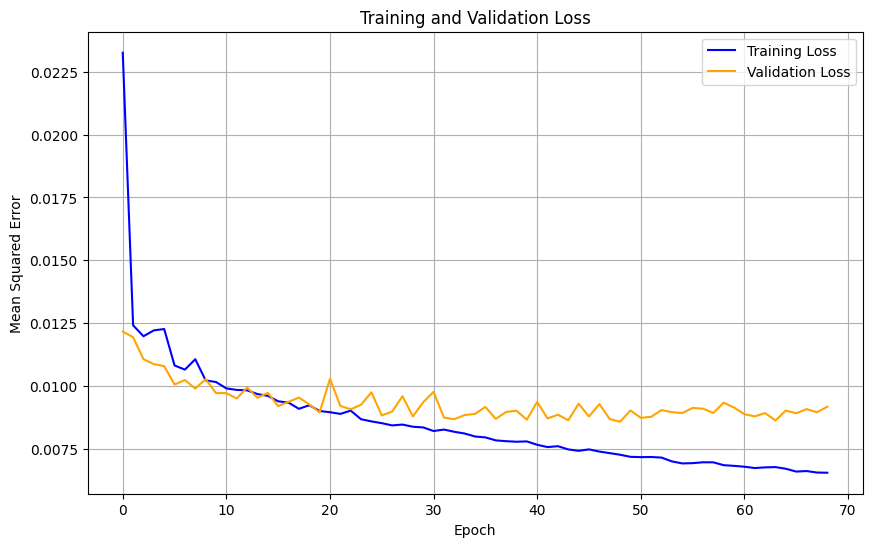

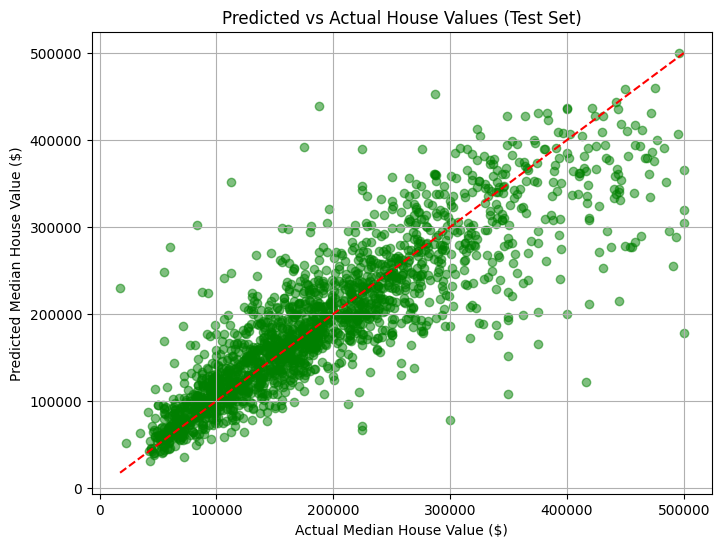

In [8]:
# Evaluate the model
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Inverse transform predictions to original scale
y_train_pred = target_scaler.inverse_transform(y_train_pred)
y_test_pred = target_scaler.inverse_transform(y_test_pred)
y_train_orig = target_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_train_pred))
train_mae = mean_absolute_error(y_train_orig, y_train_pred)
train_r2 = r2_score(y_train_orig, y_train_pred)

test_rmse = np.sqrt(mean_squared_error(y_test_orig, y_test_pred))
test_mae = mean_absolute_error(y_test_orig, y_test_pred)
test_r2 = r2_score(y_test_orig, y_test_pred)

# Display results
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test R²: {test_r2:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot of predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_test_pred, alpha=0.5, color='green')
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.title('Predicted vs Actual House Values (Test Set)')
plt.xlabel('Actual Median House Value ($)')
plt.ylabel('Predicted Median House Value ($)')
plt.grid(True)
plt.show()